# _**Semantic Segmentation on City Roads**_

## Data Wrangling

In [1]:
import os
if not os.path.exists('dataset1'):
    !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
    !unzip -q dataset1.zip
    !rm dataset1.zip
    !pip install -q torch_snippets pytorch_model_summary
from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


## Data Preprocessing

In [3]:
# Function used to transform image to Tensor and normalize the pixels
tfms = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(
                            [0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
                        ])

In [10]:
class SegData():
    def __init__(self,split:str):
        self.img_path = f"dataset1/images_prepped_{split}"
        self.annot_path = f"dataset1/annotations_prepped_{split}"
        self.items = stems(self.img_path)
        self.split  = split
    
    def __len__(self):
        return len(self.items)

    def __getitem__(self , ix):
        image = read(self.img_path + f"/{self.items[ix]}.png",1)
        image = cv2.resize(image,(224,224))
        mask = read(self.annot_path + f"/{self.items[ix]}.png")
        mask = cv2.resize(mask , (224,224))
        return image , mask 

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self , batch):
        ims , masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask)[None] for mask in masks]).long().to(device)
        return ims , ce_masks

In [11]:
trn_ds = SegData("train")
test_ds = SegData("test")
trn_dl = DataLoader(trn_ds , 
                    batch_size=4,
                    shuffle=True,
                    collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(test_ds,
                    batch_size=1,
                    collate_fn=test_ds.collate_fn)

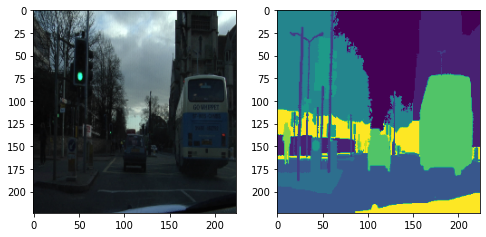

In [20]:
def view(ds:SegData,ix:int):
    img , mask = ds[ix]
    fig = plt.figure(figsize=(8,8))
    fig.add_subplot(1,2,1)
    plt.imshow(img)
    fig.add_subplot(1,2,2)
    plt.imshow(mask)
view(trn_ds,10)

## Model Building

In [21]:
def conv(ic:int , oc:int):
    return nn.Sequential(
        nn.Conv2d(ic,oc,kernel_size=3 , stride=1, padding=1),
        nn.BatchNorm2d(oc),
        nn.ReLU(inplace=True)
    )

In [22]:
def upconv(ic:int , oc:int):
    return nn.Sequential(
        nn.ConvTranspose2d(ic,oc,kernel_size=2,stride=2),
        nn.ReLU(inplace=True)
    )

In [27]:
from torchvision.models import vgg16_bn 
class U_Net(nn.Module):
    def __init__(self,oc:int,pretrained=True):
        super().__init__()
        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])
        self.bottleneck = nn.Sequential(*self.encoder[34:])

        self.convbottleneck = conv(512,1024)
        self.upconv6 = upconv(1024 , 512)
        self.conv6 = conv(512+512,512)
        self.upconv7 = upconv(512,256)
        self.conv7= conv(512+256,256)
        self.upconv8 = upconv(256,128)
        self.conv8 = conv(128+256,128)
        self.upconv9 = upconv(128,64)
        self.conv9 = conv(128+64,64)
        self.upconv10 = upconv(64,32)
        self.conv10 = conv(32+64,32) 
        self.conv11 = nn.Conv2d(32,oc,kernel_size=1)
    
    def forward(self,x):
        b1 = self.block1(x)
        b2 = self.block2(b1)
        b3 = self.block3(b2)
        b4 = self.block4(b3)
        b5 = self.block5(b4)
        bottleneck = self.bottleneck(b5) 

        x = self.convbottleneck(bottleneck)

        x = self.upconv6(x)
        x = torch.cat([x,b5],dim=1)
        x = self.conv6(x)

        x = self.upconv7(x)
        x = torch.cat([x,b4],dim=1)
        x = self.conv7(x)

        x = self.upconv8(x)
        x = torch.cat([x,b3],dim=1)
        x = self.conv8(x)

        x = self.upconv9(x)
        x = torch.cat([x,b2],dim=1)
        x = self.conv9(x)

        x = self.upconv10(x)
        x = torch.cat([x,b1],dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

In [28]:
from torchsummary import summary
model = U_Net(21)
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]           1,792
       BatchNorm2d-3         [-1, 64, 224, 224]             128
       BatchNorm2d-4         [-1, 64, 224, 224]             128
              ReLU-5         [-1, 64, 224, 224]               0
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]          36,928
            Conv2d-8         [-1, 64, 224, 224]          36,928
       BatchNorm2d-9         [-1, 64, 224, 224]             128
      BatchNorm2d-10         [-1, 64, 224, 224]             128
             ReLU-11         [-1, 64, 224, 224]               0
             ReLU-12         [-1, 64, 224, 224]               0
        MaxPool2d-13         [-1, 64, 112, 112]               0
        MaxPool2d-14         [-1, 64, 1